# グループ処理

データ分析の中で、グループ処理は特に重要な役割を果たします。この章では、Polarsのグループ処理に関する主要な関数を紹介し、それぞれの使い方と応用例を説明します。

以下の関数について詳しく見ていきます：

- `group_by`: データフレームを特定の列でグループ化します。
- `agg`: グループ化したデータに対して集計処理を行います。
- `over`: ウィンドウ関数を使用して、グループごとに計算を行います。
- `group_by_dynamic`: 時間ベースの動的なグループ化を実現します。
- `rolling`: ローリングウィンドウによる計算を行います。

これらの機能を活用することで、大規模なデータセットに対する高度な分析を効率的に行うことができます。

In [2]:
import polars as pl
from helper.jupyter import row

## group_by

`DataFrame.group_by()`メソッドを使用して、グループ化オブジェクト`GroupBy`を作成します。`maintain_order`引数を`True`に指定することで、元のデータの順序を維持したままグループ化を行います。これにより、グループの順番は元データ中に表れる順番を使用します。

In [3]:
df = pl.DataFrame(
    dict(
        g=['A', 'B', 'C', 'A', 'B', 'B'], 
        x=[1, 2, 3, 4, 5, 6])
)
g = df.group_by('g', maintain_order=True)
type(g)

polars.dataframe.group_by.GroupBy

`GroupBy`オブジェクトの`.agg()`メソッドを使用して、複数の演算式でグループごとのデータを処理し、その結果をまとめます。一部のよく使用する機能は、`GroupBy`オブジェクトのメソッドとしても提供されます。たとえば、`.mean()`は各グループの平均値を計算し、`.first()`は各グループの最初の行を出力します。以下のプログラムは、`.mean()`と`.first()`に相当する演算式の例です。

In [4]:
row(
    g.mean(), 
    g.agg(pl.all().mean()),
    g.first(),
    g.agg(pl.all().first())
)

g,x
str,f64
"""A""",2.5
"""B""",4.333333
"""C""",3.0
g,x
str,f64
"""A""",2.5
"""B""",4.333333
"""C""",3.0
g,x


`.agg()`メソッド内の演算式が複数の値を出力する場合、結果列はリストになります。`GroupBy.head()`と同じ結果を得るためには、`.explode()`を使用してリスト内のデータを縦に結合する必要があります。

In [5]:
row(
    g.head(2), 
    g.agg(pl.all().head(2)), 
    g.agg(pl.all().head(2)).explode('x')
)

g,x
str,i64
"""A""",1
"""A""",4
"""B""",2
"""B""",5
"""C""",3
g,x
str,list[i64]
"""A""","[1, 4]"
"""B""","[2, 5]"


`.agg()` メソッド内で `map_batches()` を使用してユーザー関数で演算を行う場合は、[「GroupBy.agg() 内で map_batches() を使用する」](map_batches_in_agg) を参照してください。

(over)=
## over

演算式の中で `.over()` を使うと、グループごとの処理が可能です。次のプログラムでは、`g` 列のグループごとに `x` 列の平均値を計算しています。`.group_by().agg()` を使うと、各グループにつき 1 行の結果が得られますが、`.over()` を使用すると、計算結果が元のデータに対応するすべての行に反映されます。  

In [6]:
df.with_columns(
    pl.col('x').mean()
    .over('g').alias('x_mean')
)

g,x,x_mean
str,i64,f64
"""A""",1,2.5
"""B""",2,4.333333
"""C""",3,3.0
"""A""",4,2.5
"""B""",5,4.333333
"""B""",6,4.333333


次のプログラムでは、`g` 列のグループごとに `x` 列の平均値を計算し、`x`列から平均値を引いた結果を新しい列`x_sub_mean`に格納します。この演算では、グループごとの計算結果のデータ数は変わらず、計算結果が元データの対応する行に反映されます。  

In [7]:
df.with_columns(
    (pl.col('x') - pl.col('x').mean())
    .over('g')
    .alias('x_sub_mean')
)

g,x,x_sub_mean
str,i64,f64
"""A""",1,-1.5
"""B""",2,-2.333333
"""C""",3,0.0
"""A""",4,1.5
"""B""",5,0.666667
"""B""",6,1.666667


グループごとの計算結果の長さが1でも不変でもない場合、エラーになりますが、`over()`の`mapping_strategy`引数を`'join'`に設定すると、この結果を一つのリストとして元の場所に入れます。次のプログラムでは、`g`列のグループごとに`x`列の先頭2つの値を取得し、それをリストとして新しい列に格納します。

In [8]:
df.with_columns(
    pl.col('x').head(2)
    .over('g', mapping_strategy='join')
    .alias('x_head')
)

g,x,x_head
str,i64,list[i64]
"""A""",1,"[1, 4]"
"""B""",2,"[2, 5]"
"""C""",3,[3]
"""A""",4,"[1, 4]"
"""B""",5,"[2, 5]"
"""B""",6,"[2, 5]"


次のプログラムでは、`g`列のグループごとに`x`列の最小値と最大値を取得し、それをリストとして新しい列に格納します。

In [9]:
df.with_columns(
    pl.col('x').min().append(pl.col('x').max())
    .over('g', mapping_strategy='join')
    .alias('x_min_max')
)

g,x,x_min_max
str,i64,list[i64]
"""A""",1,"[1, 4]"
"""B""",2,"[2, 6]"
"""C""",3,"[3, 3]"
"""A""",4,"[1, 4]"
"""B""",5,"[2, 6]"
"""B""",6,"[2, 6]"


`mapping_strategy`を`'explode'`に設定すると、各グループの結果を縦に結合します。これは、`group_by().agg().explode()`と同じ結果になります。次のプログラムでは、`g`列のグループごとに`x`列の先頭2つの値を取得し、各グループの結果を縦に結合します。

In [10]:
df.select(
    pl.col('g', 'x').head(2)
    .over('g', mapping_strategy='explode')
)

g,x
str,i64
"""A""",1
"""A""",4
"""B""",2
"""B""",5
"""C""",3


`filter()`メソッドにも`over()`の式を使うことができます。次のプログラムでは、`g`列のグループごとに、`x`列の値がそのグループの平均値以上の行をフィルタリングして出力します。

In [11]:
df.filter(
    (pl.col('x') >= pl.col('x').mean())
    .over('g')
)

g,x
str,i64
"""C""",3
"""A""",4
"""B""",5
"""B""",6


## group_by_dynamic

`group_by_dynamic(index)` メソッドは、`index` 列の値に基づいて動的にグループ化を行います。グループの開始点 `start` は、`start_by`、`every`、`offset` などの引数、および `index` 列の最初の値 `value` によって決まります。`start_by` 引数がデフォルト値の `"window"` の場合、`start` は次のように計算されます：

```
start = value - (value - offset) % every
```

`start_by` 引数が `"datapoint"` の場合、`start` は最初の値 `value` になります。

`start` の値が決まると、次の式で各グループの範囲が計算されます。`period` 引数のデフォルト値は `every` と同じです。

```
[start, start + period)
[start + every, start + every + period)
...
[start + i * every, start + i * every + period)
```

各グループの開始値は、そのグループのキーになります。`include_boundaries` 引数が `True` の場合、集計結果に `_lower_boundary` と `_upper_boundary` の 2 つの列が追加され、それぞれグループの開始値（含まれる）と終了値（含まれない）を表します。

たとえば、次のプログラムでは、`index` 列の値に基づき、3 単位の移動量で 3 単位ごとにグループ化し、それぞれのグループに対して集計を行います。  

In [19]:
index = [1, 2, 4, 5, 6, 8, 9, 10, 11]
df = pl.DataFrame(dict(index=index)).set_sorted('index')

g = df.group_by_dynamic('index', every='3i', offset='0i', include_boundaries=True)
row(df, g.agg(pl.col("index").alias('index_in_group')))

index
i64
1
2
4
5
6
8
9
10
11


分かりやすくするために、本書では `plot_group_by_dynamic()` 関数を使用して、`group_by_dynamic()` の結果を可視化します。出力されるグラフでは、青い線がグループ化の基準となる `index` 列の値を示し、赤い線がグループ化後のキー列の値を表します。緑のブロックは各グループの範囲を示しており、この関数は各グループに属する `index` の値も出力します。  

[[1, 2], [4, 5], [6, 8], [9, 10, 11]]


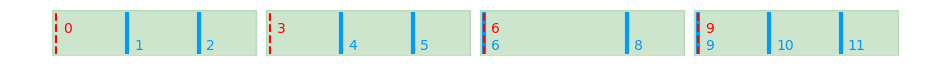

In [82]:
from helper import utils
from helper.utils import plot_group_by_dynamic
from matplotlib import pyplot as plt
plt.ioff()
plot_group_by_dynamic(index, every='3i', offset='0i')

次に、`offset` 引数の影響を示すグラフを出力します。

[[1, 2], [4, 5, 6], [8, 9], [10, 11]]


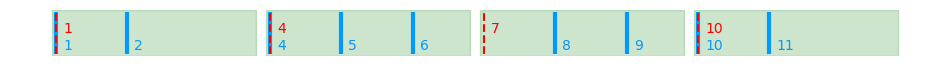

In [77]:
plot_group_by_dynamic(index, every='3i', offset='1i')

[[1], [2, 4], [5, 6], [8, 9, 10], [11]]


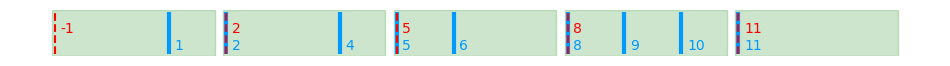

In [78]:
plot_group_by_dynamic(index, every='3i', offset='2i')

[[1], [2, 4], [5, 6], [8, 9, 10], [11]]


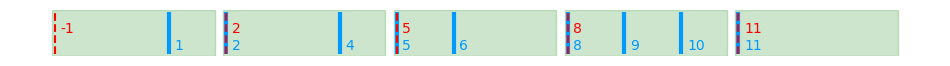

In [79]:
plot_group_by_dynamic(index, every='3i', offset='-1i')

`start_by` 引数を `'datapoint'` に設定すると、最初のグループの開始値は `index` 列の最初の値に固定されるため、`offset` 引数は無効になります。

[[1, 2], [4, 5, 6], [8, 9], [10, 11]]


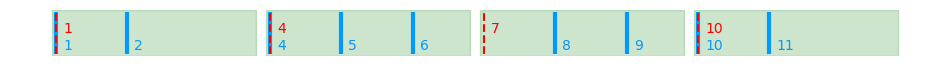

In [80]:
plot_group_by_dynamic(index, every='3i', start_by='datapoint')

`period` 引数のデフォルト値は `every` と同じであるため、各グループのウィンドウは重なりません。しかし、`period` を `every` より大きく設定すると、ウィンドウが重なり、一部の `index` 値が複数のグループに属するようになります。

[[1, 2, 4], [4, 5, 6], [6, 8, 9, 10], [9, 10, 11]]


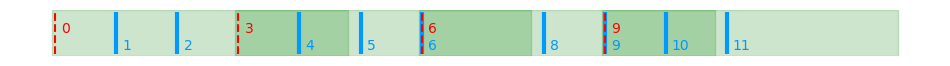

In [81]:
plot_group_by_dynamic(index, every='3i', period='5i')

次のプログラムでは、`index` 列に基づいて 1 単位ずつ移動しながら、3 単位ごとにグループ化を行います。

In [48]:
g = df.group_by_dynamic('index', every='1i', period='3i', include_boundaries=True)
row(df, g.agg(pl.col("index").alias('index_in_group')))

index
i64
1
2
4
5
6
8
9
10
11


上の例では、分かりやすくするために整数列を用いてグループ化の方法を示しましたが、実際には時系列データに対してグループ化を行うことが一般的です。時系列データの場合、`every`、`period`、`offset` などの単位は、次のような形式で指定できます：

- `1ns`  （1ナノ秒）  
- `1us`  （1マイクロ秒）  
- `1ms`  （1ミリ秒）  
- `1s`   （1秒）  
- `1m`   （1分）  
- `1h`   （1時間）  
- `1d`   （1暦日）  
- `1w`   （1暦週）  
- `1mo`  （1暦月）  
- `1q`   （1暦四半期）  
- `1y`   （1暦年）  

これらの単位を使用することで、時系列データを柔軟にグループ化できます。

## rolling  

`rolling(index)` メソッドは、`index` 列の値に基づいてローリングウィンドウを作成します。`period` および `offset` 引数を指定することで、ウィンドウの相対位置を調整できます。デフォルトでは、`offset` の値は `-period` に設定されています。  

ローリングウィンドウの範囲は次のように決まります。`()` 側の値は含まれず、`[]` 側の値は含まれるため、開始値は除外され、終了値は含まれます。  

```
(index[0] + offset, index[0] + offset + period]
...
(index[i] + offset, index[i] + offset + period]
```

次のプログラムでは、`index` 列に基づいて、直前の 2 つのデータ点を含む 3 点のローリングウィンドウを作成し、そのウィンドウ内で集計を行います。  

In [13]:
g = df.rolling('index', period='3i')
g.agg(pl.col("value"))

index,value
i64,list[i64]
4,[4]
5,"[4, 5]"
9,[9]
10,"[9, 10]"
11,"[9, 10, 11]"
12,"[10, 11, 12]"
13,"[11, 12, 13]"


次のプログラムでは、`index` 列に基づき、各データ点とその後の 2 つのデータ点を含む 3 点のローリングウィンドウを作成し、そのウィンドウ内で集計を行います。  

In [14]:
g = df.rolling('index', period='3i', offset='-1i')
g.agg(pl.col("value"))

index,value
i64,list[i64]
4,"[4, 5]"
5,[5]
9,"[9, 10, 11]"
10,"[10, 11, 12]"
11,"[11, 12, 13]"
12,"[12, 13]"
13,[13]


固定点数の移動窓で処理する場合は、`int_range()`で作成した行番号に対して`rolling`処理を行います。以下のプログラムでは、データフレームの各行に対して、前の2つの行を含む合計3行のローリングウィンドウを適用し、`A`列の最大値と`B`列の最小値を計算します。

次のコードでは、`int_range(0, pl.len())`を使って行番号を生成し、その行番号に基づいてローリングウィンドウを作成します。ウィンドウの期間は3行（`period='3i'`）で、`offset='-2i'`により、各ウィンドウは現在の行の2行前から始まります。集計では、`A`列の最大値と`B`列の最小値が計算され、結果として各行に対してこれらの統計値が追加されます。

In [15]:
df = pl.DataFrame(
    dict(
        A=[5, 3, 8, 9, 10, 1, 2, 4],
        B=[10, 20, 10, 2, 3, 5, 0, 7]
    )
)

(
    df
    .rolling(
        pl.int_range(0, pl.len()).alias('index'), 
        period='3i', 
        offset='-2i'
    )
    .agg(
        pl.col.A,
        pl.col.B,
        pl.col.A.max().alias('A_max'),
        pl.col.B.min().alias('B_min'),
    )
)

index,A,B,A_max,B_min
i64,list[i64],list[i64],i64,i64
0,"[5, 3]","[10, 20]",5,10
1,"[5, 3, 8]","[10, 20, 10]",8,10
2,"[3, 8, 9]","[20, 10, 2]",9,2
3,"[8, 9, 10]","[10, 2, 3]",10,2
4,"[9, 10, 1]","[2, 3, 5]",10,2
5,"[10, 1, 2]","[3, 5, 0]",10,0
6,"[1, 2, 4]","[5, 0, 7]",4,0
7,"[2, 4]","[0, 7]",4,0


Polars には `Expr.rolling()` も用意されています。引数は `DataFrame.rolling()` と同じですが、`Expr.rolling()` は列単位で適用できるため、より柔軟なデータ処理が可能です。`.rolling()` はローリングウィンドウ内の要素をコンテキストとして使用し、直前の演算に適用されます。

次の例では、同じ `rolling()` 演算を以下の 2 つの式に適用しています。  

- **`pl.col('A')`**: 集計処理がないため、ローリングウィンドウ内の要素をリストとしてそのまま出力します。  
- **`pl.col('A').max()`**: ローリングウィンドウ内の要素リストに対して `max()` を適用し、各ウィンドウ内の最大値を計算して出力します。

In [20]:
df.with_row_index().select(
    pl.col('A').rolling('index', period='3i', offset='-2i'),
    pl.col('A').max().rolling('index', period='3i', offset='-2i').alias('A_max')
)

A,A_max
list[i64],i64
"[5, 3]",5
"[5, 3, 8]",8
"[3, 8, 9]",9
"[8, 9, 10]",10
"[9, 10, 1]",10
"[10, 1, 2]",10
"[1, 2, 4]",4
"[2, 4]",4


注意すべき点は、`.rolling()` は **直前のすべての演算式に対して** 適用されることです。  

1. **`pl.col('A').diff().max().rolling(...)` の挙動** ❶
   - まず、A列の要素がローリングウィンドウに分割されます。  
   - その後、それぞれのウィンドウ内で `.diff().max()` が適用されます。  

2. **A列の差分を計算した後にローリングウィンドウを適用する方法** ❷
   - まず `dA = pl.col('A').diff()` を計算し、新しい列 `dA` を作成します。  
   - 次に、`dA` に対して `pl.col('dA').max().rolling(...)` を計算します。  

この違いを理解することで、意図した通りにローリングウィンドウを適用できます。

In [34]:
df1 = df.select('A').with_row_index().with_columns(
    pl.col('A').rolling('index', period='3i'),
    pl.col('A').diff().rolling('index', period='3i').alias('dA_rolling'),
    pl.col('A').diff().max().rolling('index', period='3i').alias('dA_max_rolling') #❶
)

df2 = df.select('A').with_row_index().with_columns(
    pl.col('A').diff().alias('dA') #❷
).with_columns(
    pl.col('dA').rolling('index', period='3i').alias('dA_rolling'),
    pl.col('dA').max().rolling('index', period='3i').alias('dA_max_rolling') #❷
)

row(df1, df2)

shape: (8, 4) index A dA_rolling dA_max_rolling u32 list[i64] list[i64] i64 0 [5] [null] null 1 [5, 3] [null, -2] -2 2 [5, 3, 8] [null, -2, 5] 5 3 [3, 8, 9] [null, 5, 1] 5 4 [8, 9, 10] [null, 1, 1] 1 5 [9, 10, 1] [null, 1, -9] 1 6 [10, 1, 2] [null, -9, 1] 1 7 [1, 2, 4] [null, 1, 2] 2 
 shape: (8, 5) index A dA dA_rolling dA_max_rolling u32 i64 i64 list[i64] i64 0 5 null [null] null 1 3 -2 [null, -2] -2 2 8 5 [null, -2, 5] 5 3 9 1 [-2, 5, 1] 5 4 10 1 [5, 1, 1] 5 5 1 -9 [1, 1, -9] 1 6 2 1 [1, -9, 1] 1 7 4 2 [-9, 1, 2] 2

## CookBook

### 値の変化に応じたグループ化と集計

次のプログラムでは、`g`列の値が変化するたびにグループを変え、各グループの最初の`g`の値と`v`列の値を取得します。`rle_id()`を使用して、`g`列の値が変化するたびに新しいグループIDを割り当てます。`rle_id()`は、連続する同じ値に同じIDを割り当て、値が変化するたびにIDを更新します。

In [16]:
df = pl.DataFrame(
    {
        "g": [1, 1, 2, 2, 2, 1, 1, 0],
        "v": list(range(8))
    }
)

df.group_by(
    pl.col('g').rle_id().alias('group_id')
).agg(
    pl.col('g').first(),
    pl.col('v')
)

group_id,g,v
u32,i64,list[i64]
0,1,"[0, 1]"
1,2,"[2, 3, 4]"
2,1,"[5, 6]"
3,0,[7]


### グループ毎に番号付け

c1列とc2列の値に番号を付けます。番号は0からスタート、新しい値が現れるたびに１増加します。

In [7]:
df = pl.DataFrame(
    {
        "c1": ["b", "a", "a", "b", "c", "a", "b"],
        "c2": [2, 1, 1, 1, 1, 1, 1],
    }
)

#### group_byで計算

1. `group_by("c1", "c2", maintain_order=True)`:
   - `df`データフレームを、`c1`列と`c2`列の組み合わせでグループ化します。これにより、`c1`と`c2`のユニークなペアごとにグループが作られます。

2. `pl.col("c1").agg_groups().alias("row_index")`:
   - グループ化した後、`c1`列に対して`agg_groups()`関数を使用しています。`agg_groups()`は、各グループ内で行のインデックスをリストとして取得するものです。ここでは、各グループ内のインデックスを`row_index`という名前で新しい列として追加します。

3. `with_row_index()`:
   - `with_row_index()`は、グループ化後のデータフレームに行番号（インデックス）を追加します。

4. `explode("row_index")`:
   - `explode()`は、リストや配列を展開して、それぞれのリスト要素を新しい行に分割する操作です。ここでは、`row_index`列に格納されているインデックスのリストを展開して、各インデックスを新しい行として扱います。この操作によって、複数の行が作成され、`row_index`の要素が個々の行に分割されます。

5. `sort(by="row_index")`:
   - `row_index`を基準にデータをソートします。このソートによって、`row_index`の値が小さい順に行が並び、元のデータフレームと同じ順序になります。

6. `drop('row_index')`:
   - 最後に、`row_index`列を削除します。これは、インデックス付けを行った後、最終的に不要な列を削除するためです。

In [17]:
(
    df
    .group_by("c1", "c2", maintain_order=True)
    .agg(
        pl.col("c1")
        .agg_groups()
        .alias("row_index")
    )
    .with_row_index()
    .explode("row_index")
    .sort(by="row_index")
    .drop('row_index')
)

index,c1,c2
u32,str,i64
0,"""b""",2
1,"""a""",1
1,"""a""",1
2,"""b""",1
3,"""c""",1
1,"""a""",1
2,"""b""",1


#### joinで計算

`join`操作で同じ結果が得られます。

1. `df.select('c1', 'c2')`:
   - `df`データフレームから、`c1`列と`c2`列だけを選択しています。これにより、`df`の中でこの2つの列に関する操作が後続の処理で行われるようになります。

2. `unique(maintain_order=True)`:
   - `unique()`メソッドは、指定した列のユニークな値を取得します。この場合、`c1`列と`c2`列の組み合わせに基づいてユニークなペアを抽出します。`maintain_order=True`を指定しているため、元の順番が保持されます（ユニークな値を抽出する際、データフレームの順番が変わらないようにします）。

3. `with_row_index()`:
   - `with_row_index()`は、データフレームに行番号（インデックス）を追加します。

4. `df.join(..., on=["c1", "c2"])`:
   - 最後に、元の`df`データフレームと、`c1`と`c2`のユニークな組み合わせ（インデックスが付けられたもの）を`join`します。`on=["c1", "c2"]`は、`c1`と`c2`の列を基準に結合を行うことを示します。

In [9]:
df.join(
    df.select('c1', 'c2')
    .unique(maintain_order=True)
    .with_row_index(),
    on=["c1", "c2"]
)

c1,c2,index
str,i64,u32
"""b""",2,0
"""a""",1,1
"""a""",1,1
"""b""",1,2
"""c""",1,3
"""a""",1,1
"""b""",1,2


#### カテゴリカル型で計算

`c1`列と`c2`列の値を結合して新しい文字列を作成し、それをカテゴリカル型（`Categorical`）に変換した後、整数型に変換することで同じ結果が得られます。

1. `pl.format("{} - {}", "c1", "c2")`:
   - `pl.format()`関数を使用して、`c1`列と`c2`列の値をフォーマットして結合します。
   - `{}`はプレースホルダで、`c1`と`c2`の値がそれぞれここに挿入されます。この場合、`c1`と`c2`の各値を`"c1の値 - c2の値"`という形式で結合した文字列が生成されます。
   - 例えば、`c1`が`"a"`、`c2`が`1`の場合、`"a - 1"`という文字列が作成されます。

2. `cast(pl.Categorical)`:
   - `cast(pl.Categorical)`は、作成された文字列列を`Categorical`型に変換します。`Categorical`型は、列の値が限られたユニークなカテゴリーである場合に効率的に格納できるデータ型です。

3. `to_physical()`:
    - `to_physical()`は、列を物理的に格納する形式に変換します。`Categorical`型の場合、各カテゴリーに対応する整数値が得られます。

4. `alias("index")`:
   - 最後に、新しく作成した列に`index`という名前を付けます。

In [18]:
df.with_columns(
    pl.format("{} - {}", "c1", "c2")
    .cast(pl.Categorical)
    .to_physical()
    .alias("index")
)

c1,c2,index
str,i64,u32
"""b""",2,0
"""a""",1,1
"""a""",1,1
"""b""",1,2
"""c""",1,3
"""a""",1,1
"""b""",1,2


#### 構造体とカテゴリカル型で計算

`pl.format()`が使えない場合は、次のように構造体列をカテゴリカル型に変換することもできます。

1. `pl.struct("c1", "c2")`:
   - `pl.struct("c1", "c2")`は、`c1`列と`c2`列を構造体（`struct`）としてまとめます。これにより、`c1`と`c2`のペアを一つの構造体として扱うことができます。構造体を作ることで、これらの列の組み合わせを一つの新しい単位として処理できるようになります。

2. `rank("dense")`:
   - `rank("dense")`は、構造体（`c1`と`c2`のペア）を基にして、データを「密なランク（dense ranking）」でランク付けします。密なランクは、同じ値に対して同じランクを与え、ランクが抜けないようにします（例えば、1位が2人の場合、次は3位になります）。この処理により、`c1`と`c2`の組み合わせに対してランクが割り当てられます。

3. `cast(pl.String)`:
   - `cast(pl.String)`は、ランク付けされた値は整数ですが、これを直接カテゴリー型に変換できないため、一旦文字列型（`String`）に変換します。

In [25]:
df.with_columns(
    pl.struct("c1", "c2")
    .rank("dense")
    .cast(pl.String)
    .cast(pl.Categorical)
    .to_physical()
    .alias("index")
)

c1,c2,index
str,i64,u32
"""b""",2,0
"""a""",1,1
"""a""",1,1
"""b""",1,2
"""c""",1,3
"""a""",1,1
"""b""",1,2
